In [1]:
import os,sys
from collections import defaultdict
import json
import numpy as np
import pickle
from skimage import io
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
%load_ext autoreload
%autoreload 2

In [31]:
PATH = '/home/eddyod/programming/pipeline_utility'
MESH_DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes'
VOL_DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes'
sys.path.append(PATH)
from utilities.sqlcontroller import SqlController
from utilities.imported_atlas_utilities import load_original_volume_all_known_structures_v3, get_centroid_3d, \
    load_alignment_results_v3, transform_points, average_location, \
    convert_to_original_name, name_unsided_to_color, paired_structures, \
    convert_to_left_name, convert_to_right_name, load_original_volume_v2, save_alignment_results_v3, \
    convert_transform_forms, transform_volume_v4, volume_to_polydata, singular_structures, \
    MESH_DIR, average_shape, convert_to_surround_name, mirror_volume_v2, save_original_volume, \
    save_mesh_stl, get_surround_volume_v2, transform_volume_v4, high_contrast_colors, \
    plot_centroid_means_and_covars_3d, all_known_structures_sided, load_data, \
    get_instance_mesh_filepath, images_to_volume_v2, find_contour_points, load_cropbox_v2, \
    load_mean_shape, \
    display_volume_sections, get_structure_mean_positions_filepath, all_known_structures_unsided_including_surround_200um
from utilities.aligner_v3 import Aligner
from utilities.alignment_utility import convert_resolution_string_to_um
from utilities.conversion import *
from utilities.utilities_view import launch_vtk, add_axes

In [3]:
INPUT_KEY_LOC = os.path.join(PATH, 'neuroglancer', 'structure_key_minimal.json')
NUM_STRUCTS = 49
with open(INPUT_KEY_LOC, 'r') as f:
    structures = json.load(f)
structures = list(structures.values())
#structures = structures[0:9]

In [ ]:
structures = ['IC', 'SC']

In [4]:
atlas_name = 'atlasV7'
fixed_brain_name = 'MD589'
moving_brain_names = ['MD585', 'MD594']
resolution = '10.0um'
resolution_um = 10.0
structure_centroids_all_brains_um_wrt_fixed = []
fixed_brain_spec = {'name': fixed_brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}

In [5]:
fixed_brain = load_original_volume_all_known_structures_v3(stack_spec=fixed_brain_spec, structures=structures, 
                                                           in_bbox_wrt='wholebrain')
fixed_brain_structure_centroids = get_centroid_3d(fixed_brain)
fixed_brain_structure_centroids_um = {s: c * resolution_um for s, c in fixed_brain_structure_centroids.items()}
structure_centroids_all_brains_um_wrt_fixed.append(fixed_brain_structure_centroids_um)

## Compute instance centroids

In [6]:
for brain_m in moving_brain_names:
    moving_brain_spec = {'name': brain_m, 'vol_type': 'annotationAsScore', 'resolution': resolution}
    print('Brain', moving_brain_spec)
    moving_brain = load_original_volume_all_known_structures_v3(stack_spec=moving_brain_spec, 
                                                                structures=structures, in_bbox_wrt='wholebrain')
    alignment_spec = dict(stack_m=moving_brain_spec, stack_f=fixed_brain_spec, warp_setting=109)
    moving_brain_structure_centroids_input_resol = get_centroid_3d(moving_brain)
    # Load registration.
    # Alignment results fp: os.path.join(reg_root_dir, alignment_spec['stack_m']['name'], warp_basename, warp_basename + '_' + what + '.' + ext)
    transform_parameters_moving_brain_to_fixed_brain = load_alignment_results_v3(alignment_spec=alignment_spec, what='parameters')
    # Transform moving brains into alignment with the fixed brain.
    transformed_moving_brain_structure_centroids_input_resol_wrt_fixed = \
    dict(list(zip(list(moving_brain_structure_centroids_input_resol.keys()),
                  transform_points(pts=list(moving_brain_structure_centroids_input_resol.values()),
                                   transform=transform_parameters_moving_brain_to_fixed_brain))))

    transformed_moving_brain_structure_centroids_um_wrt_fixed = \
        {s: c * resolution_um for s, c in
        list(transformed_moving_brain_structure_centroids_input_resol_wrt_fixed.items())}

    structure_centroids_all_brains_um_wrt_fixed.append(transformed_moving_brain_structure_centroids_um_wrt_fixed)


Brain {'name': 'MD585', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
Brain {'name': 'MD594', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}


In [7]:
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed = defaultdict(list)
for sc in structure_centroids_all_brains_um_wrt_fixed:
    for k, c in sc.items():
        structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed[k].append(c)
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed.default_factory = None

## Compute standard centroids

In [8]:
nominal_centroids_wrt_canonicalAtlasSpace_um, \
instance_centroids_wrt_canonicalAtlasSpace_um, \
canonical_center_wrt_fixed_um, \
canonical_normal, \
transform_matrix_to_canonicalAtlasSpace_um = \
average_location(structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed)

PBG Mid-sagittal plane normal vector = [ 0.03060831 -0.09308818  0.99518728]
Mid-sagittal plane anchor wrt fixed wholebrain = [11866.90779861  5625.28799858  4664.04047394]


In [9]:
colors = {name_s: np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.
                                        for name_s in instance_centroids_wrt_canonicalAtlasSpace_um.keys()}

In [ ]:
colors

No handles with labels found to put in legend.


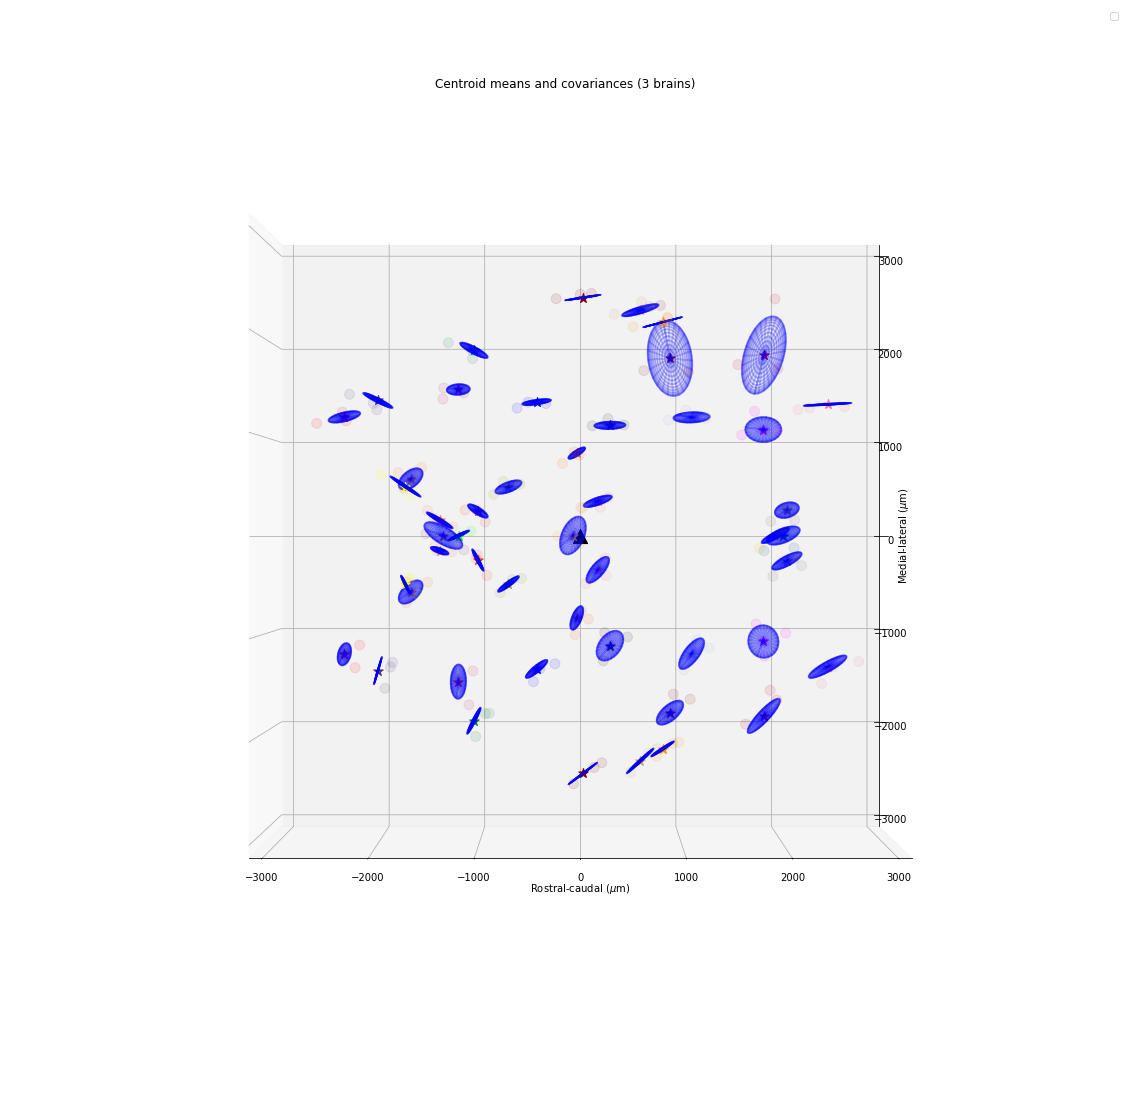

In [11]:
plot_centroid_means_and_covars_3d(instance_centroids=instance_centroids_wrt_canonicalAtlasSpace_um,
                                 nominal_locations=nominal_centroids_wrt_canonicalAtlasSpace_um,
                                 canonical_centroid=(0,0,0),
                                  show_canonical_centroid=True,
                                  canonical_normal=[0,0,1],
                                 colors=colors,
                                 xlim=[-3000, 3000],
                                 ylim=[-3000, 3000],
                                 zlim=[-3000, 3000],
                                 xlabel='Rostral-caudal ($\mu$m)',
                                 ylabel='',
                                 zlabel='Medial-lateral ($\mu$m)',
                                 title='Centroid means and covariances (3 brains)')

In [12]:
filepath = os.path.join(MESH_DIR, atlas_name, '1um_meanPositions.pkl')
with open(filepath, 'wb') as f:
    pickle.dump(nominal_centroids_wrt_canonicalAtlasSpace_um, f)

In [13]:
filepath = os.path.join(MESH_DIR, atlas_name, 'canonicalCentroid_wrt_fixedWholebrain.txt')
np.savetxt(filepath, canonical_center_wrt_fixed_um)

In [14]:
reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')

In [15]:
# Note that all shapes have voxel resolution matching input resolution (10.0 micron).
for structure in structures:
    # for structure in all_known_structures:
    # Load instance volumes.
    instance_volumes = []
    instance_source = []

    if structure in paired_structures:
        left_name = convert_to_left_name(structure)
        right_name = convert_to_right_name(structure)
    else:
        left_name = structure
        right_name = structure

    for brain_name in [fixed_brain_name] + moving_brain_names:
        brain_spec = {'name': brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}
        right_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec,
                                                        structure=right_name,
                                                        return_origin_instead_of_bbox=True,
                                                        crop_to_minimal=True)
        instance_volumes.append(right_instance_vol)  # if right, do not mirror
        instance_source.append((brain_name, 'R'))

        left_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec,
                                                       structure=left_name,
                                                       return_origin_instead_of_bbox=True,
                                                       crop_to_minimal=True)
        instance_volumes.append(left_instance_vol[..., ::-1])  # if left, mirror
        instance_source.append((brain_name, 'L'))

   # Use the first instance as registration target.
    # Register every other instance to the first instance.
    template_instance_volume = instance_volumes[0]
    template_instance_centroid_wrt_templateOrigin = get_centroid_3d(template_instance_volume).astype(np.int16)
    template_instance_wrt_templateCentroid = (template_instance_volume, - template_instance_centroid_wrt_templateOrigin)
    aligned_moving_instance_wrt_templateCentroid_all_instances = []

    for i in range(1, len(instance_volumes)):
        print('Registering {} instance {} to instance 0'.format(structure, i))
        # Compute transform.
        moving_instance_volume = instance_volumes[i]
        aligner = Aligner({0: template_instance_wrt_templateCentroid},
                          {0: (moving_instance_volume, np.array((0,0,0)))},
                          labelIndexMap_m2f={0:0},
                         verbose=False)
        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
        aligner.compute_gradient(smooth_first=True)
        lr = 1.
        ### max_iter_num was originally 100 and 1000
        print('Entering aligner optimzer')
        _, _ = aligner.optimize(tf_type='rigid',
                                history_len=100,
                                max_iter_num=2 if structure in ['SC', 'IC'] else 3,
                                grad_computation_sample_number=None,
                                full_lr=np.array([lr, lr, lr, 0.1, 0.1, 0.1]),
                                terminate_thresh_trans=.01)



        reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')
        save_alignment_results_v3(aligner=aligner,
                              select_best='max_value',
                              alignment_spec=dict(warp_setting=108,
                                                  stack_f=dict(name='%s_instance0' % structure, vol_type='annotationAsScore'),
                                                  stack_m=dict(name='%s_instance%d' % (structure, i),
                                                               vol_type='annotationAsScore')),
                              reg_root_dir=reg_root_dir)

        # Transform instances.
        T = convert_transform_forms(aligner=aligner, out_form=(3, 4), select_best='max_value')
        aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
            transform_volume_v4(volume=(moving_instance_volume, (0, 0, 0)), transform=T,
                                return_origin_instead_of_bbox=True)
        aligned_moving_instance_wrt_templateCentroid = (
        aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)
        aligned_moving_instance_wrt_templateCentroid_all_instances.append(aligned_moving_instance_wrt_templateCentroid)

    # Generate meshes for each instance.
    volume_origin_list = [template_instance_wrt_templateCentroid] + aligned_moving_instance_wrt_templateCentroid_all_instances
    instance_mesh_wrt_templateCentroid_all_instances = [volume_to_polydata(volume, num_simplify_iter=3, smooth=True)
        for volume, o in volume_origin_list]

    # Save meshes.
    for i, mesh_data in enumerate(instance_mesh_wrt_templateCentroid_all_instances):
        meshfile = '{}_{}_{}.stl'.format(resolution, structure, str(i))
        meshpath = os.path.join(MESH_DIR, atlas_name, 'aligned_instance_meshes', meshfile)
        #print('Save stl at {}'.format( meshpath))
        save_mesh_stl(mesh_data, meshpath)

    filename = '{}_sources.pkl'.format(structure)
    filepath = os.path.join(MESH_DIR, atlas_name, 'instance_sources', filename)
    with open(filepath, 'wb') as f:
        pickle.dump(instance_source, f)

    # Compute average shape.

    if structure == 'IC' or structure == 'SC':
        # IC and SC boundaries are particularly jagged, so do a larger value smoothing.
        sigma = 5.
    else:
        sigma = 2.


    mean_shape_wrt_templateCentroid = \
        average_shape(volume_origin_list=volume_origin_list, force_symmetric=(structure in singular_structures),
                      sigma=sigma,
                      )

    for surface_level in np.arange(0.1, 1.1, .1):
        print("level =", surface_level, ', volume =',
              np.count_nonzero(mean_shape_wrt_templateCentroid[0] > surface_level) * resolution_um ** 3 / 1e9, "mm^3")

    # Generate meshes for mean shape.
    mean_shape_isosurface_polydata_all_levels = {surface_level:
                                                     volume_to_polydata(
                                                         (mean_shape_wrt_templateCentroid[0] >= surface_level,
                                                         mean_shape_wrt_templateCentroid[1]),
                                                         num_simplify_iter=3, smooth=True)
        for surface_level in np.arange(0.1, 1.1, .1)}

    # Identify the surrouding area as additional structure.

    wall_level = .5
    surround_distance_um = 200.

    # changed to v2 to v3 Jul/27/2020 renamed without the _vX
    # volume, distance=5, wall_level=0, prob=False, return_origin_instead_of_bbox=True, padding=5
    # def get_surround_volume(volume, origin, distance=5, wall_level=0, prob=False, return_origin_instead_of_bbox=True,
    #                        padding=5):
    surround_wrt_stdShapeCentroid = \
        get_surround_volume_v2(vol=mean_shape_wrt_templateCentroid[0],
                               origin=mean_shape_wrt_templateCentroid[1],
                               distance=surround_distance_um / resolution_um,
                               wall_level=wall_level,
                               prob=True,
                               return_origin_instead_of_bbox=True,
                               padding=5)

    # Generate meshes for surrouding area.
    surround_isosurface_polydata_all_levels = {surface_level:
             volume_to_polydata((surround_wrt_stdShapeCentroid[0] >= surface_level,
                                surround_wrt_stdShapeCentroid[1]),
                                num_simplify_iter=3, smooth=True)
         for surface_level in np.arange(0.1, 1.1, .1)}

    # Save mean shape.
    filename = '{}_{}_volume.npy'.format(resolution, structure)
    filepath =  os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    np.save(filepath, np.ascontiguousarray(mean_shape_wrt_templateCentroid[0]))

    filename = '{}_{}_origin_wrt_meanShapeCentroid.txt'.format(resolution, structure)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    np.savetxt(filepath, mean_shape_wrt_templateCentroid[1])


    for level in np.arange(0.1, 1.1, .1):
        filename = '{}_{}_mesh_level_{}.stl'.format(resolution, structure, str(level))
        filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
        save_mesh_stl(mean_shape_isosurface_polydata_all_levels[level], filepath)

    surround_name = convert_to_surround_name(structure, margin=str(int(surround_distance_um)) + 'um')
    filename = '{}_{}_volume.npy'.format(resolution, surround_name)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    np.save(filepath, np.ascontiguousarray(surround_wrt_stdShapeCentroid[0]))


    filename = '{}_{}_origin_wrt_meanShapeCentroid.txt'.format(resolution, surround_name)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    np.savetxt(filepath, surround_wrt_stdShapeCentroid[1])

    for level in np.arange(0.1, 1.1, .1):
        filename = '{}_{}_{}.stl'.format(resolution, surround_name, str(level))
        filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
        save_mesh_stl(surround_isosurface_polydata_all_levels[level], filepath)


Registering 10N_L instance 1 to instance 0
Entering aligner optimzer
Registering 10N_L instance 2 to instance 0
Entering aligner optimzer
Registering 10N_L instance 3 to instance 0
Entering aligner optimzer
Registering 10N_L instance 4 to instance 0
Entering aligner optimzer
Registering 10N_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.037841 mm^3
level = 0.2 , volume = 0.025776 mm^3
level = 0.30000000000000004 , volume = 0.018669 mm^3
level = 0.4 , volume = 0.014137 mm^3
level = 0.5 , volume = 0.010822 mm^3
level = 0.6 , volume = 0.008146 mm^3
level = 0.7000000000000001 , volume = 0.005798 mm^3
level = 0.8 , volume = 0.003516 mm^3
level = 0.9 , volume = 0.000983 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 10N_R instance 1 to instance 0
Entering aligner optimzer
Registering 10N_R instance 2 to instance 0
Entering aligner optimzer
Registering 10N_R instance 3 to instance 0
Entering aligner optimzer
Registering 10N_R instance 4 to instance 0
Entering aligner optimzer
Registering 10N_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.03837 mm^3
level = 0.2 , volume = 0.025782 mm^3
level = 0.30000000000000004 , volume = 0.018027 mm^3
level = 0.4 , volume = 0.012846 mm^3
level = 0.5 , volume = 0.009453 mm^3
level = 0.6 , volume = 0.006776 mm^3
level = 0.7000000000000001 , volume = 0.004406 mm^3
level = 0.8 , volume = 0.002078 mm^3
level = 0.9 , volume = 0.000372 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 12N instance 1 to instance 0
Entering aligner optimzer
Registering 12N instance 2 to instance 0
Entering aligner optimzer
Registering 12N instance 3 to instance 0
Entering aligner optimzer
Registering 12N instance 4 to instance 0
Entering aligner optimzer
Registering 12N instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.128242 mm^3
level = 0.2 , volume = 0.113269 mm^3
level = 0.30000000000000004 , volume = 0.103154 mm^3
level = 0.4 , volume = 0.094851 mm^3
level = 0.5 , volume = 0.087315 mm^3
level = 0.6 , volume = 0.080055 mm^3
level = 0.7000000000000001 , volume = 0.072614 mm^3
level = 0.8 , volume = 0.064194 mm^3
level = 0.9 , volume = 0.053205 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 3N_L instance 1 to instance 0
Entering aligner optimzer
Registering 3N_L instance 2 to instance 0
Entering aligner optimzer
Registering 3N_L instance 3 to instance 0
Entering aligner optimzer
Registering 3N_L instance 4 to instance 0
Entering aligner optimzer
Registering 3N_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.045171 mm^3
level = 0.2 , volume = 0.032985 mm^3
level = 0.30000000000000004 , volume = 0.024639 mm^3
level = 0.4 , volume = 0.017411 mm^3
level = 0.5 , volume = 0.01359 mm^3
level = 0.6 , volume = 0.01074 mm^3
level = 0.7000000000000001 , volume = 0.0084 mm^3
level = 0.8 , volume = 0.006211 mm^3
level = 0.9 , volume = 0.003942 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 3N_R instance 1 to instance 0
Entering aligner optimzer
Registering 3N_R instance 2 to instance 0
Entering aligner optimzer
Registering 3N_R instance 3 to instance 0
Entering aligner optimzer
Registering 3N_R instance 4 to instance 0
Entering aligner optimzer
Registering 3N_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.039002 mm^3
level = 0.2 , volume = 0.028596 mm^3
level = 0.30000000000000004 , volume = 0.022268 mm^3
level = 0.4 , volume = 0.017652 mm^3
level = 0.5 , volume = 0.014245 mm^3
level = 0.6 , volume = 0.011192 mm^3
level = 0.7000000000000001 , volume = 0.008334 mm^3
level = 0.8 , volume = 0.005862 mm^3
level = 0.9 , volume = 0.003637 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 4N_L instance 1 to instance 0
Entering aligner optimzer
Registering 4N_L instance 2 to instance 0
Entering aligner optimzer
Registering 4N_L instance 3 to instance 0
Entering aligner optimzer
Registering 4N_L instance 4 to instance 0
Entering aligner optimzer
Registering 4N_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.003879 mm^3
level = 0.2 , volume = 0.002372 mm^3
level = 0.30000000000000004 , volume = 0.001606 mm^3
level = 0.4 , volume = 0.001093 mm^3
level = 0.5 , volume = 0.000732 mm^3
level = 0.6 , volume = 0.00046 mm^3
level = 0.7000000000000001 , volume = 0.000244 mm^3
level = 0.8 , volume = 9.2e-05 mm^3
level = 0.9 , volume = 3e-06 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 4N_R instance 1 to instance 0
Entering aligner optimzer
Registering 4N_R instance 2 to instance 0
Entering aligner optimzer
Registering 4N_R instance 3 to instance 0
Entering aligner optimzer
Registering 4N_R instance 4 to instance 0
Entering aligner optimzer
Registering 4N_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.004115 mm^3
level = 0.2 , volume = 0.002818 mm^3
level = 0.30000000000000004 , volume = 0.002017 mm^3
level = 0.4 , volume = 0.001441 mm^3
level = 0.5 , volume = 0.001039 mm^3
level = 0.6 , volume = 0.000703 mm^3
level = 0.7000000000000001 , volume = 0.000448 mm^3
level = 0.8 , volume = 0.000235 mm^3
level = 0.9 , volume = 6e-05 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 5N_L instance 1 to instance 0
Entering aligner optimzer
Registering 5N_L instance 2 to instance 0
Entering aligner optimzer
Registering 5N_L instance 3 to instance 0
Entering aligner optimzer
Registering 5N_L instance 4 to instance 0
Entering aligner optimzer
Registering 5N_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.145594 mm^3
level = 0.2 , volume = 0.118698 mm^3
level = 0.30000000000000004 , volume = 0.100609 mm^3
level = 0.4 , volume = 0.086604 mm^3
level = 0.5 , volume = 0.07417 mm^3
level = 0.6 , volume = 0.063043 mm^3
level = 0.7000000000000001 , volume = 0.0523 mm^3
level = 0.8 , volume = 0.041784 mm^3
level = 0.9 , volume = 0.029615 mm^3
level = 1.0 , volume = 5e-06 mm^3
Registering 5N_R instance 1 to instance 0
Entering aligner optimzer
Registering 5N_R instance 2 to instance 0
Entering aligner optimzer
Registering 5N_R instance 3 to instance 0
Entering aligner optimzer
Registering 5N_R instance 4 to instance 0
Entering aligner op

mesh_to_polydata: No faces are provided, so skip simplification.


Registering 6N_R instance 1 to instance 0
Entering aligner optimzer
Registering 6N_R instance 2 to instance 0
Entering aligner optimzer
Registering 6N_R instance 3 to instance 0
Entering aligner optimzer
Registering 6N_R instance 4 to instance 0
Entering aligner optimzer
Registering 6N_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.006306 mm^3
level = 0.2 , volume = 0.004295 mm^3
level = 0.30000000000000004 , volume = 0.003166 mm^3
level = 0.4 , volume = 0.002359 mm^3
level = 0.5 , volume = 0.001729 mm^3
level = 0.6 , volume = 0.001239 mm^3
level = 0.7000000000000001 , volume = 0.00083 mm^3
level = 0.8 , volume = 0.000471 mm^3
level = 0.9 , volume = 0.000163 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering 7N_L instance 1 to instance 0
Entering aligner optimzer
Registering 7N_L instance 2 to instance 0
Entering aligner optimzer
Registering 7N_L instance 3 to instance 0
Entering aligner optimzer
Registering 7N_L instance 4 to instance 0
Entering aligner optimzer
Registering 7N_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.271907 mm^3
level = 0.2 , volume = 0.232089 mm^3
level = 0.30000000000000004 , volume = 0.205053 mm^3
level = 0.4 , volume = 0.180727 mm^3
level = 0.5 , volume = 0.155525 mm^3
level = 0.6 , volume = 0.134701 mm^3
level = 0.7000000000000001 , volume = 0.117977 mm^3
level = 0.8 , volume = 0.101375 mm^3
level = 0.9 , volume = 0.081884 mm^3
level = 1.0 , volume = 0.001511 mm^3
Registering 7N_R instance 1 to instance 0
Entering aligner optimzer
Registering 7N_R instance 2 to instance 0
Entering aligner optimzer
Registering 7N_R instance 3 to instance 0
Entering aligner optimzer
Registering 7N_R instance 4 to instance 0
Entering alig

mesh_to_polydata: No faces are provided, so skip simplification.


Registering Amb_R instance 1 to instance 0
Entering aligner optimzer
Registering Amb_R instance 2 to instance 0
Entering aligner optimzer
Registering Amb_R instance 3 to instance 0
Entering aligner optimzer
Registering Amb_R instance 4 to instance 0
Entering aligner optimzer
Registering Amb_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.009766 mm^3
level = 0.2 , volume = 0.0069 mm^3
level = 0.30000000000000004 , volume = 0.00528 mm^3
level = 0.4 , volume = 0.004123 mm^3
level = 0.5 , volume = 0.003225 mm^3
level = 0.6 , volume = 0.00248 mm^3
level = 0.7000000000000001 , volume = 0.001811 mm^3
level = 0.8 , volume = 0.0012 mm^3
level = 0.9 , volume = 0.000587 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering AP instance 1 to instance 0
Entering aligner optimzer
Registering AP instance 2 to instance 0
Entering aligner optimzer
Registering AP instance 3 to instance 0
Entering aligner optimzer
Registering AP instance 4 to instance 0
Entering aligner optimzer
Registering AP instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.017691 mm^3
level = 0.2 , volume = 0.01438 mm^3
level = 0.30000000000000004 , volume = 0.012265 mm^3
level = 0.4 , volume = 0.010483 mm^3
level = 0.5 , volume = 0.009198 mm^3
level = 0.6 , volume = 0.007834 mm^3
level = 0.7000000000000001 , volume = 0.006634 mm^3
level = 0.8 , volume = 0.005328 mm^3
level = 0.9 , volume = 0.003778 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering DC_L instance 1 to instance 0
Entering aligner optimzer
Registering DC_L instance 2 to instance 0
Entering aligner optimzer
Registering DC_L instance 3 to instance 0
Entering aligner optimzer
Registering DC_L instance 4 to instance 0
Entering aligner optimzer
Registering DC_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.288314 mm^3
level = 0.2 , volume = 0.218434 mm^3
level = 0.30000000000000004 , volume = 0.178605 mm^3
level = 0.4 , volume = 0.143093 mm^3
level = 0.5 , volume = 0.076588 mm^3
level = 0.6 , volume = 0.05236 mm^3
level = 0.7000000000000001 , volume = 0.040227 mm^3
level = 0.8 , volume = 0.03081 mm^3
level = 0.9 , volume = 0.021666 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering DC_R instance 1 to instance 0
Entering aligner optimzer
Registering DC_R instance 2 to instance 0
Entering aligner optimzer
Registering DC_R instance 3 to instance 0
Entering aligner optimzer
Registering DC_R instance 4 to instance 0
Entering aligner optimzer
Registering DC_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.298335 mm^3
level = 0.2 , volume = 0.236372 mm^3
level = 0.30000000000000004 , volume = 0.193519 mm^3
level = 0.4 , volume = 0.153279 mm^3
level = 0.5 , volume = 0.093267 mm^3
level = 0.6 , volume = 0.068091 mm^3
level = 0.7000000000000001 , volume = 0.055636 mm^3
level = 0.8 , volume = 0.044937 mm^3
level = 0.9 , volume = 0.033698 mm^3
level = 1.0 , volume = 0.000327 mm^3
Registering IC instance 1 to instance 0
Entering aligner optimzer
Registering IC instance 2 to instance 0
Entering aligner optimzer
Registering IC instance 3 to instance 0
Entering aligner optimzer
Registering IC instance 4 to instance 0
Entering aligner opti

mesh_to_polydata: No faces are provided, so skip simplification.


Registering LC_L instance 1 to instance 0
Entering aligner optimzer
Registering LC_L instance 2 to instance 0
Entering aligner optimzer
Registering LC_L instance 3 to instance 0
Entering aligner optimzer
Registering LC_L instance 4 to instance 0
Entering aligner optimzer
Registering LC_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.053444 mm^3
level = 0.2 , volume = 0.041362 mm^3
level = 0.30000000000000004 , volume = 0.03326 mm^3
level = 0.4 , volume = 0.027231 mm^3
level = 0.5 , volume = 0.022311 mm^3
level = 0.6 , volume = 0.017867 mm^3
level = 0.7000000000000001 , volume = 0.013725 mm^3
level = 0.8 , volume = 0.009777 mm^3
level = 0.9 , volume = 0.005807 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering LC_R instance 1 to instance 0
Entering aligner optimzer
Registering LC_R instance 2 to instance 0
Entering aligner optimzer
Registering LC_R instance 3 to instance 0
Entering aligner optimzer
Registering LC_R instance 4 to instance 0
Entering aligner optimzer
Registering LC_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.056138 mm^3
level = 0.2 , volume = 0.041274 mm^3
level = 0.30000000000000004 , volume = 0.031909 mm^3
level = 0.4 , volume = 0.024842 mm^3
level = 0.5 , volume = 0.019425 mm^3
level = 0.6 , volume = 0.01518 mm^3
level = 0.7000000000000001 , volume = 0.011441 mm^3
level = 0.8 , volume = 0.008044 mm^3
level = 0.9 , volume = 0.004664 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering LRt_L instance 1 to instance 0
Entering aligner optimzer
Registering LRt_L instance 2 to instance 0
Entering aligner optimzer
Registering LRt_L instance 3 to instance 0
Entering aligner optimzer
Registering LRt_L instance 4 to instance 0
Entering aligner optimzer
Registering LRt_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.206062 mm^3
level = 0.2 , volume = 0.157265 mm^3
level = 0.30000000000000004 , volume = 0.126804 mm^3
level = 0.4 , volume = 0.101103 mm^3
level = 0.5 , volume = 0.076697 mm^3
level = 0.6 , volume = 0.058486 mm^3
level = 0.7000000000000001 , volume = 0.045252 mm^3
level = 0.8 , volume = 0.032309 mm^3
level = 0.9 , volume = 0.018821 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering LRt_R instance 1 to instance 0
Entering aligner optimzer
Registering LRt_R instance 2 to instance 0
Entering aligner optimzer
Registering LRt_R instance 3 to instance 0
Entering aligner optimzer
Registering LRt_R instance 4 to instance 0
Entering aligner optimzer
Registering LRt_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.244135 mm^3
level = 0.2 , volume = 0.192296 mm^3
level = 0.30000000000000004 , volume = 0.158006 mm^3
level = 0.4 , volume = 0.128454 mm^3
level = 0.5 , volume = 0.102112 mm^3
level = 0.6 , volume = 0.079711 mm^3
level = 0.7000000000000001 , volume = 0.058466 mm^3
level = 0.8 , volume = 0.038565 mm^3
level = 0.9 , volume = 0.020293 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering PBG_L instance 1 to instance 0
Entering aligner optimzer
Registering PBG_L instance 2 to instance 0
Entering aligner optimzer
Registering PBG_L instance 3 to instance 0
Entering aligner optimzer
Registering PBG_L instance 4 to instance 0
Entering aligner optimzer
Registering PBG_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.029263 mm^3
level = 0.2 , volume = 0.018778 mm^3
level = 0.30000000000000004 , volume = 0.011609 mm^3
level = 0.4 , volume = 0.007488 mm^3
level = 0.5 , volume = 0.005106 mm^3
level = 0.6 , volume = 0.003589 mm^3
level = 0.7000000000000001 , volume = 0.002449 mm^3
level = 0.8 , volume = 0.001508 mm^3
level = 0.9 , volume = 0.000678 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering PBG_R instance 1 to instance 0
Entering aligner optimzer
Registering PBG_R instance 2 to instance 0
Entering aligner optimzer
Registering PBG_R instance 3 to instance 0
Entering aligner optimzer
Registering PBG_R instance 4 to instance 0
Entering aligner optimzer
Registering PBG_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.026432 mm^3
level = 0.2 , volume = 0.017335 mm^3
level = 0.30000000000000004 , volume = 0.012497 mm^3
level = 0.4 , volume = 0.009475 mm^3
level = 0.5 , volume = 0.007233 mm^3
level = 0.6 , volume = 0.005349 mm^3
level = 0.7000000000000001 , volume = 0.003742 mm^3
level = 0.8 , volume = 0.002404 mm^3
level = 0.9 , volume = 0.001178 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering Pn_L instance 1 to instance 0
Entering aligner optimzer
Registering Pn_L instance 2 to instance 0
Entering aligner optimzer
Registering Pn_L instance 3 to instance 0
Entering aligner optimzer
Registering Pn_L instance 4 to instance 0
Entering aligner optimzer
Registering Pn_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.452984 mm^3
level = 0.2 , volume = 0.374351 mm^3
level = 0.30000000000000004 , volume = 0.326603 mm^3
level = 0.4 , volume = 0.285753 mm^3
level = 0.5 , volume = 0.250544 mm^3
level = 0.6 , volume = 0.220017 mm^3
level = 0.7000000000000001 , volume = 0.188308 mm^3
level = 0.8 , volume = 0.161946 mm^3
level = 0.9 , volume = 0.132783 mm^3
level = 1.0 , volume = 0.002147 mm^3
Registering Pn_R instance 1 to instance 0
Entering aligner optimzer
Registering Pn_R instance 2 to instance 0
Entering aligner optimzer
Registering Pn_R instance 3 to instance 0
Entering aligner optimzer
Registering Pn_R instance 4 to instance 0
Entering alig

mesh_to_polydata: No faces are provided, so skip simplification.


Registering RMC_R instance 1 to instance 0
Entering aligner optimzer
Registering RMC_R instance 2 to instance 0
Entering aligner optimzer
Registering RMC_R instance 3 to instance 0
Entering aligner optimzer
Registering RMC_R instance 4 to instance 0
Entering aligner optimzer
Registering RMC_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.157534 mm^3
level = 0.2 , volume = 0.105593 mm^3
level = 0.30000000000000004 , volume = 0.085241 mm^3
level = 0.4 , volume = 0.069242 mm^3
level = 0.5 , volume = 0.0578 mm^3
level = 0.6 , volume = 0.048875 mm^3
level = 0.7000000000000001 , volume = 0.0412 mm^3
level = 0.8 , volume = 0.03345 mm^3
level = 0.9 , volume = 0.024723 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering RtTg instance 1 to instance 0
Entering aligner optimzer
Registering RtTg instance 2 to instance 0
Entering aligner optimzer
Registering RtTg instance 3 to instance 0
Entering aligner optimzer
Registering RtTg instance 4 to instance 0
Entering aligner optimzer
Registering RtTg instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.708171 mm^3
level = 0.2 , volume = 0.588291 mm^3
level = 0.30000000000000004 , volume = 0.514087 mm^3
level = 0.4 , volume = 0.455578 mm^3
level = 0.5 , volume = 0.406505 mm^3
level = 0.6 , volume = 0.361685 mm^3
level = 0.7000000000000001 , volume = 0.318181 mm^3
level = 0.8 , volume = 0.273662 mm^3
level = 0.9 , volume = 0.212969 mm^3
level = 1.0 , volume = 0.004608 mm^3
Registering SC instance 1 to instance 0
Entering aligner optimzer
Registering SC instance 2 to instance 0
Entering aligner optimzer
Registering SC instance 3 to instance 0
Entering aligner optimzer
Registering SC instance 4 to instance 0
Entering aligner opti

mesh_to_polydata: No faces are provided, so skip simplification.
mesh_to_polydata: No faces are provided, so skip simplification.


Registering SNC_R instance 1 to instance 0
Entering aligner optimzer
Registering SNC_R instance 2 to instance 0
Entering aligner optimzer
Registering SNC_R instance 3 to instance 0
Entering aligner optimzer
Registering SNC_R instance 4 to instance 0
Entering aligner optimzer
Registering SNC_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.095535 mm^3
level = 0.2 , volume = 0.049141 mm^3
level = 0.30000000000000004 , volume = 0.026387 mm^3
level = 0.4 , volume = 0.011264 mm^3
level = 0.5 , volume = 0.003428 mm^3
level = 0.6 , volume = 0.001976 mm^3
level = 0.7000000000000001 , volume = 0.001017 mm^3
level = 0.8 , volume = 0.000348 mm^3
level = 0.9 , volume = 0.0 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.
mesh_to_polydata: No faces are provided, so skip simplification.


Registering SNR_L instance 1 to instance 0
Entering aligner optimzer
Registering SNR_L instance 2 to instance 0
Entering aligner optimzer
Registering SNR_L instance 3 to instance 0
Entering aligner optimzer
Registering SNR_L instance 4 to instance 0
Entering aligner optimzer
Registering SNR_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.793326 mm^3
level = 0.2 , volume = 0.677849 mm^3
level = 0.30000000000000004 , volume = 0.594226 mm^3
level = 0.4 , volume = 0.505934 mm^3
level = 0.5 , volume = 0.329056 mm^3
level = 0.6 , volume = 0.247723 mm^3
level = 0.7000000000000001 , volume = 0.209191 mm^3
level = 0.8 , volume = 0.179382 mm^3
level = 0.9 , volume = 0.147748 mm^3
level = 1.0 , volume = 0.015284 mm^3
Registering SNR_R instance 1 to instance 0
Entering aligner optimzer
Registering SNR_R instance 2 to instance 0
Entering aligner optimzer
Registering SNR_R instance 3 to instance 0
Entering aligner optimzer
Registering SNR_R instance 4 to instance 0
Ente

mesh_to_polydata: No faces are provided, so skip simplification.


Registering Tz_R instance 1 to instance 0
Entering aligner optimzer
Registering Tz_R instance 2 to instance 0
Entering aligner optimzer
Registering Tz_R instance 3 to instance 0
Entering aligner optimzer
Registering Tz_R instance 4 to instance 0
Entering aligner optimzer
Registering Tz_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.072145 mm^3
level = 0.2 , volume = 0.058002 mm^3
level = 0.30000000000000004 , volume = 0.048805 mm^3
level = 0.4 , volume = 0.041616 mm^3
level = 0.5 , volume = 0.035433 mm^3
level = 0.6 , volume = 0.030011 mm^3
level = 0.7000000000000001 , volume = 0.02501 mm^3
level = 0.8 , volume = 0.020094 mm^3
level = 0.9 , volume = 0.014446 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


Registering VCA_L instance 1 to instance 0
Entering aligner optimzer
Registering VCA_L instance 2 to instance 0
Entering aligner optimzer
Registering VCA_L instance 3 to instance 0
Entering aligner optimzer
Registering VCA_L instance 4 to instance 0
Entering aligner optimzer
Registering VCA_L instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.295543 mm^3
level = 0.2 , volume = 0.239482 mm^3
level = 0.30000000000000004 , volume = 0.202881 mm^3
level = 0.4 , volume = 0.171954 mm^3
level = 0.5 , volume = 0.132863 mm^3
level = 0.6 , volume = 0.107893 mm^3
level = 0.7000000000000001 , volume = 0.091174 mm^3
level = 0.8 , volume = 0.075422 mm^3
level = 0.9 , volume = 0.058523 mm^3
level = 1.0 , volume = 0.000732 mm^3
Registering VCA_R instance 1 to instance 0
Entering aligner optimzer
Registering VCA_R instance 2 to instance 0
Entering aligner optimzer
Registering VCA_R instance 3 to instance 0
Entering aligner optimzer
Registering VCA_R instance 4 to instance 0
Ente

mesh_to_polydata: No faces are provided, so skip simplification.


Registering VCP_R instance 1 to instance 0
Entering aligner optimzer
Registering VCP_R instance 2 to instance 0
Entering aligner optimzer
Registering VCP_R instance 3 to instance 0
Entering aligner optimzer
Registering VCP_R instance 4 to instance 0
Entering aligner optimzer
Registering VCP_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.137726 mm^3
level = 0.2 , volume = 0.10776 mm^3
level = 0.30000000000000004 , volume = 0.088061 mm^3
level = 0.4 , volume = 0.072543 mm^3
level = 0.5 , volume = 0.059189 mm^3
level = 0.6 , volume = 0.049683 mm^3
level = 0.7000000000000001 , volume = 0.042223 mm^3
level = 0.8 , volume = 0.035345 mm^3
level = 0.9 , volume = 0.027963 mm^3
level = 1.0 , volume = 0.000417 mm^3
Registering VLL_L instance 1 to instance 0
Entering aligner optimzer
Registering VLL_L instance 2 to instance 0
Entering aligner optimzer
Registering VLL_L instance 3 to instance 0
Entering aligner optimzer
Registering VLL_L instance 4 to instance 0
Enter

mesh_to_polydata: No faces are provided, so skip simplification.


Registering VLL_R instance 1 to instance 0
Entering aligner optimzer
Registering VLL_R instance 2 to instance 0
Entering aligner optimzer
Registering VLL_R instance 3 to instance 0
Entering aligner optimzer
Registering VLL_R instance 4 to instance 0
Entering aligner optimzer
Registering VLL_R instance 5 to instance 0
Entering aligner optimzer
level = 0.1 , volume = 0.238014 mm^3
level = 0.2 , volume = 0.173917 mm^3
level = 0.30000000000000004 , volume = 0.134306 mm^3
level = 0.4 , volume = 0.10246 mm^3
level = 0.5 , volume = 0.065236 mm^3
level = 0.6 , volume = 0.04815 mm^3
level = 0.7000000000000001 , volume = 0.037428 mm^3
level = 0.8 , volume = 0.028319 mm^3
level = 0.9 , volume = 0.019376 mm^3
level = 1.0 , volume = 0.0 mm^3


mesh_to_polydata: No faces are provided, so skip simplification.


In [16]:
len(instance_volumes)

6

In [17]:
i = 1
# Compute transform.
moving_instance_volume = instance_volumes[i]
aligner = Aligner({0: template_instance_wrt_templateCentroid}, 
                  {0: (moving_instance_volume, np.array((0,0,0)))}, 
                  labelIndexMap_m2f={0:0})
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
aligner.compute_gradient(smooth_first=True)
lr = .1
_, _ = aligner.optimize(tf_type='rigid', 
                     history_len=100, 
                    max_iter_num=100 if structure in ['SC', 'IC'] else 10000,
                     grad_computation_sample_number=None,
                        full_lr=np.array([lr,lr,lr,0.1,0.1,0.1]),
                       terminate_thresh_trans=.01)

In [18]:
moving_instance_volume.shape, moving_instance_volume.dtype

((206, 94, 59), dtype('bool'))

In [19]:
filename = os.path.join(VOL_DIR, atlas_name, 'moving_instance_volume.npy')
print(filename)
np.save(filename, moving_instance_volume)

/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV7/moving_instance_volume.npy


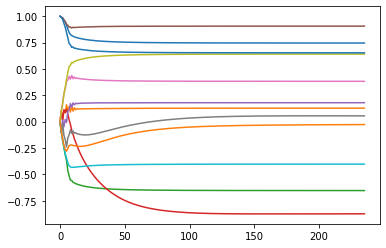

In [20]:
plt.plot(aligner.Ts);

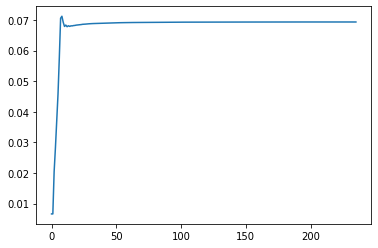

In [21]:
plt.plot(aligner.scores);

In [ ]:
# doesn't display much
# Transform instances.

T = convert_transform_forms(aligner=aligner, out_form=(3,4), select_best='max_value')

aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
transform_volume_v4((moving_instance_volume, (0,0,0)), transform=T,
                    return_origin_instead_of_bbox=True)

aligned_moving_instance_wrt_templateCentroid = (aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)        

# Generate meshes for each instance.

instance_mesh_wrt_templateCentroid_all_instances = [
volume_to_polydata((v, o), num_simplify_iter=3, smooth=True)
for v, o in 
[template_instance_wrt_templateCentroid] + [aligned_moving_instance_wrt_templateCentroid]]

In [ ]:
# crashes the kernel
#launch_vtk([actor_mesh(mesh, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1) 
#    for i, mesh in enumerate([instance_mesh_wrt_templateCentroid_all_instances[0],
#                             instance_mesh_wrt_templateCentroid_all_instances[1]])], 
#  background_color=(1,1,1))


# Visualize Results

In [ ]:
# for name_u in all_known_structures:
for name_u in structures:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
#         try:
        scores = load_alignment_results_v3(what='scoreHistory', alignment_spec=dict(warp_setting=108, 
                          stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                         stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                 reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')) 

        axes[i-1].plot(scores);
        axes[i-1].set_title('%s_instance%d' % (name_u, i))
    plt.show();

In [ ]:
# for name_u in all_known_structures:
for name_u in structures:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
        trajectory = load_alignment_results_v3(what='trajectory',
                          alignment_spec=dict(warp_setting=108, 
                                              stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                                             stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                                     reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration'))        
        axes[i-1].plot(trajectory);
        axes[i-1].set_title('%s_instance%d' % (name_u, i))
    plt.show();

In [ ]:
for name_u in structures:
    # Load instance meshes.
    instance_meshes = []
    for i in range(6):
        filepath = get_instance_mesh_filepath(atlas_name=atlas_name, structure=name_u,index=i, resolution='10um')
        m = load_data(filepath, filetype='stl')
        if m is not None:
            instance_meshes.append(m)

    #launch_vtk([actor_mesh(m, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1, wireframe_linewidth=3) 
    #    for i, m in enumerate(instance_meshes)], 
    #  background_color=(1,1,1))
    
    # Load average shape.
    filepath = get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='volume', resolution='10.0um')
    vol = load_data(filepath, filetype='stl')
    filepath = get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='origin_wrt_meanShapeCentroid', resolution='10.0um')
    ori_wrt_meanShapeCentroid = load_data(filepath, filetype='stl')
    
    standard_shape_volume_actor = actor_volume(vol.astype(np.float32), 
                                               what='probability', 
                                               origin=ori_wrt_meanShapeCentroid, 
                                              c=(0,0,0))
    
    #launch_vtk([standard_shape_volume_actor])

# Combine standard shapes with standard centroid locations

In [22]:
#atlas_name = 'atlasVT'
atlas_resolution = '10.0um'
atlas_resolution_um = 10.0

In [23]:
filepath = get_structure_mean_positions_filepath(atlas_name=atlas_name, resolution='1um')
all_known_structures = all_known_structures_unsided_including_surround_200um()
nominal_centroids_wrt_canonicalAtlasSpace_um = load_data(filepath, filetype='pkl')
nominal_centroids_wrt_canonicalAtlasSpace_10um = {s: c / atlas_resolution_um for s, c in nominal_centroids_wrt_canonicalAtlasSpace_um.items()}

mean_shapes_10um_wrt_stdShapeCentroid = {name_u: load_mean_shape(atlas_name=atlas_name, structure=name_u, resolution=atlas_resolution) 
                    for name_u in all_known_structures}

In [24]:
atlas_spec = dict(name=atlas_name, vol_type='score', resolution=atlas_resolution)

In [28]:
structures

['10N_L',
 '10N_R',
 '12N',
 '3N_L',
 '3N_R',
 '4N_L',
 '4N_R',
 '5N_L',
 '5N_R',
 '6N_L',
 '6N_R',
 '7N_L',
 '7N_R',
 'Amb_L',
 'Amb_R',
 'AP',
 'DC_L',
 'DC_R',
 'IC',
 'LC_L',
 'LC_R',
 'LRt_L',
 'LRt_R',
 'PBG_L',
 'PBG_R',
 'Pn_L',
 'Pn_R',
 'RMC_L',
 'RMC_R',
 'RtTg',
 'SC',
 'SNC_L',
 'SNC_R',
 'SNR_L',
 'SNR_R',
 'Sp5C_L',
 'Sp5C_R',
 'Sp5I_L',
 'Sp5I_R',
 'Sp5O_L',
 'Sp5O_R',
 'Tz_L',
 'Tz_R',
 'VCA_L',
 'VCA_R',
 'VCP_L',
 'VCP_R',
 'VLL_L',
 'VLL_R']

In [32]:
## TODO: simplify this.
# mean_shape_wrt_canonicalAtlasSpace_all_structures_10um = {}
structures = ['10N']
for name_u in structures:
# for name_u in ['7N']:
#     mean_shape_10um, mean_shape_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[name_u]
#     mean_shape_surround_10um, mean_shape_surround_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')]
    
    if name_u in singular_structures:                
        for name in [name_u, convert_to_surround_name(name_u, margin='200um')]:
            mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name][0], 
                        mean_shapes_10um_wrt_stdShapeCentroid[name][1] + 
                                                       nominal_centroids_wrt_canonicalAtlasSpace_10um[name_u])
#             mean_shape_wrt_canonicalAtlasSpace_all_structures_10um[name] = mean_shape_wrt_canonicalAtlasSpace_10um
            #save_original_volume(volume=mean_shape_wrt_canonicalAtlasSpace_10um, stack_spec=atlas_spec, structure=name, wrt='canonicalAtlasSpace')
            print('mean_shape_wrt', np.shape(mean_shape_wrt_canonicalAtlasSpace_10um))
    else:
        
        left_name = convert_to_left_name(name_u)
        left_surround_name = convert_to_surround_name(left_name, margin='200um')
        right_name = convert_to_right_name(name_u)
        right_surround_name = convert_to_surround_name(right_name, margin='200um')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(volume=mean_shapes_10um_wrt_stdShapeCentroid[name_u],
             centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[name_u][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])

        save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_name, wrt='canonicalAtlasSpace')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(\
            volume=mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0],
            centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])        
        
        save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_surround_name, wrt='canonicalAtlasSpace')
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name_u][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[name_u][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_name, wrt='canonicalAtlasSpace')
            
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_surround_name, wrt='canonicalAtlasSpace')

volume filepath 10N_L.npy
origin filepath /net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV7/None_annotationAsScoreVolume/10N_L_origin_wrt_canonicalAtlasSpace.txt
volume filepath 10N_L_surround_200um.npy
origin filepath /net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV7/None_annotationAsScoreVolume/10N_L_surround_200um_origin_wrt_canonicalAtlasSpace.txt
volume filepath 10N_R.npy
origin filepath /net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV7/None_annotationAsScoreVolume/10N_R_origin_wrt_canonicalAtlasSpace.txt
volume filepath 10N_R_surround_200um.npy
origin filepath /net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV7/None_annotationAsScoreVolume/10N_R_surround_200um_origin_wrt_canonicalAtlasSpace.txt


# Convert to vtk polydata for visualization

In [ ]:
#for name_s in all_known_structures_sided_including_surround_200um:
for name_s in structures:
    atlas_structure_wrt_canonicalAtlasSpace = \
    load_original_volume_v2(stack_spec=atlas_spec, structure=name_s, bbox_wrt='canonicalAtlasSpace')

    for surface_level in np.arange(0.1, 1.1, .1):
        mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace = \
        volume_to_polydata(volume=(atlas_structure_wrt_canonicalAtlasSpace[0] >= surface_level, atlas_structure_wrt_canonicalAtlasSpace[1]), 
                     num_simplify_iter=3, smooth=True, 
                     return_vertex_face_list=False)
        path = '/home/eddyod/tmp/meshes'
        if surface_level == 0.2:
            filepath = os.path.join(path, '{}_{}.stl'.format(name_s, surface_level))
            save_mesh_stl(mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace, filepath)
        #save_data(mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace, 
        #          DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=surface_level))

In [ ]:
mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures = \
{name_s: load_data(DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=0.5))
for name_s in all_known_structures_sided}

In [ ]:
#launch_vtk([actor_mesh(v, wireframe=False, opacity=.5, color=name_unsided_to_color_float[convert_to_original_name(s)]) 
#            for s, v in mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
#          + [actor_sphere([0,0,0])])

# Shell

Just use MD589's shell, until we find a way to average the outlines.

In [ ]:
stack_fixed = 'MD589'
MASKS = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/masks/{}/aligned'.format(stack_fixed)
margin_um = 200
in_resolution_um = 0.46 * 32
margin_tb = margin_um / XY_PIXEL_DISTANCE_TB
for stack in ['MD589']:
    #sqlController = SqlController(stack)
#     contours_valid_by_z = {}
    contour_prob_maps_by_sec = {} 
    sections = sorted(os.listdir(MASKS))
    i = 1
    for sec in sections[0:10]:
        maskfile = os.path.join(MASKS, sec)
        m = io.imread(maskfile)
        contours = find_contour_points(m, sample_every=1)[1]
        contours_valid = [cnt[(cnt[:,0] >= 1) & (cnt[:,1] >= 1)] for cnt in contours]
#         z = np.mean(DataManager.convert_section_to_z(stack, sec, downsample=32, z_begin=0))
#         contours_valid_by_z[z] = contours_valid[0]
        m2 = np.zeros_like(m, np.bool)
        for cnt in contours_valid:
            m2[cnt[:,1], cnt[:,0]] = 1
        distance_to_contour = distance_transform_edt(~m2)
        contour_prob_map = np.exp(-distance_to_contour**2/(2*margin_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0
        contour_prob_maps_by_sec[i] = contour_prob_map
        i += 1
        
outline_prob_volume_atlasResol, outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol = \
images_to_volume_v2(images=contour_prob_maps_by_sec, spacing_um=20, 
                    in_resol_um = in_resolution_um,
                    out_resol_um = atlas_resolution_um)                                                                    
#outline_prob_volume_bbox (xm,xm,ym,ym) relative to cropped, (zm,zm) relative to uncropped.
# crop_box = metadata_cache['cropbox']['MD589']
alignedBrainstemCrop_cropbox_down32 = load_cropbox_v2(stack=stack_fixed, prep_id='alignedBrainstemCrop')
alignedBrainstemCrop_cropbox_atlasResol = alignedBrainstemCrop_cropbox_down32 * in_resolution_um / atlas_resolution_um
outline_prob_volume_origin_rel2fixedwholebrain_atlasResol = outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol + (alignedBrainstemCrop_cropbox_atlasResol[0], alignedBrainstemCrop_cropbox_atlasResol[2], 0)
#display_volume_sections(outline_prob_volume, direction='z', ncols=5, cmap=plt.cm.gray, start_level=0)

In [ ]:
outline_prob_volume_origin_rel2canon_atlasResol = outline_prob_volume_origin_rel2fixedwholebrain_atlasResol - \
canonical_center_wrt_fixed_um/convert_resolution_string_to_um(resolution='10.0um')

In [ ]:
shell_vol_origin_dict_rel2canon = {'shell': (outline_prob_volume_atlasResol, outline_prob_volume_origin_rel2canon_atlasResol)}

# Side task: compute the volumes of structures

In [ ]:
atlas_resolution = '10.0um'
atlas_resolution_um = 10.0
atlas_spec = dict(name='atlasV7', vol_type='score', resolution=atlas_resolution)
volumes = load_original_volume_all_known_structures_v3(atlas_spec, 
                           structures=all_known_structures_sided, in_bbox_wrt='canonicalAtlasSpace')

volumes_mm3 = defaultdict(dict)
structures = ['SC', 'IC']
for name_u in structures:
    for level in np.arange(0, 1.1, .1):
        volumes_mm3[name_u][level] = np.count_nonzero(volumes[convert_to_left_name(name_u)][0] > level) * 10.**3 / 1e9

In [ ]:
df = pd.DataFrame(volumes_mm3)

In [ ]:
df.head()

# Load

In [ ]:
standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.5, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

In [ ]:
launch_vtk([actor_mesh(p, wireframe=True) 
           for s, p in standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Show multiple iso-surfaces

standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.1, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.9, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Load shell

stack_fixed = 'MD589'
shell_polydata_rel2fixedWholebrain = DataManager.load_mesh_v2(brain_spec={'name':stack_fixed, 
                                                                    'vol_type':'annotationAsScore',
                                                                   'resolution':'10.0um'}, 
                                                        structure='shell')

shell_polydata_rel2canonicalAtlasSpace = move_polydata(shell_polydata_rel2fixedWholebrain,
                                                       -canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

shell_actor_rel2canon = actor_mesh(shell_polydata_rel2fixedWholebrain, (1,1,1), opacity=.15, 
                              wireframe=False, origin=-canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

In [ ]:
save_data(shell_polydata_rel2canonicalAtlasSpace, 
          DataManager.get_mesh_filepath_v2(atlas_spec, structure='shell', level=None))

In [ ]:
launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)]\
#           +[shell_actor_rel2canon] \
           +[actor_mesh(shell_polydata_rel2canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)]
#           +[actor_volume(shell_vol_origin_dict_rel2canon['shell'][0].astype(np.float32), 
#                          what='probability', origin=shell_vol_origin_dict_rel2canon['shell'][1])]
          )

In [ ]:
# atlas_volume, structure_to_label, label_to_structure = \
# DataManager.load_original_volume_all_known_structures(stack=atlas_name, sided=True)

In [ ]:
vol, origin_rel2canon = structure_vol_origin_dicts_rel2canon['7N_L']

one_structure_volume_actor_rel2canon = actor_volume(vol.astype(np.float32), what='score', 
                                              origin=origin_rel2canon,
                                                    auxdata=0.8*(vol>0.1).astype(np.float32),
                                              c=np.array(name_unsided_to_color['7N'])/255.)
#                                             c=np.array((1,0,0)))

# Render

In [ ]:
launch_vtk([] \
    + structure_mesh_actors_rel2canon \
#     + [one_structure_volume_actor_rel2canon] \
#     + [shell_volume_actor_rel2canon] \
#     + structure_mesh_surround_actors_rel2canon \
    + [shell_actor_rel2canon] \
    + [actor_sphere((0,0,0), radius=1)], 
           init_angle='sagittal', 
    background_color=(1,1,1),
depth_peeling=True)